In [1]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 13336, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 13336 (delta 59), reused 70 (delta 45), pack-reused 13240
Receiving objects: 100% (13336/13336), 12.11 MiB | 22.75 MiB/s, done.
Resolving deltas: 100% (9280/9280), done.


In [2]:
!pip install wandb

In [3]:
!pip install -r yolov5/requirements.txt

In [4]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET # to convert xml to txt file
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

In [5]:
!mkdir Road_Sign_Dataset

In [6]:
!cd Road_Sign_Dataset

In [7]:
!ls yolov5

CONTRIBUTING.md  data	    hubconf.py	      setup.cfg       utils
LICENSE		 detect.py  models	      train.py	      val.py
README.md	 export.py  requirements.txt  tutorial.ipynb


In [8]:
!wget -O RoadSignDetectionDataset.zip https://arcraftimages.s3-accelerate.amazonaws.com/Datasets/RoadSigns/RoadSignsPascalVOC.zip?region=us-east-2

--2022-05-14 11:51:32--  https://arcraftimages.s3-accelerate.amazonaws.com/Datasets/RoadSigns/RoadSignsPascalVOC.zip?region=us-east-2
Resolving arcraftimages.s3-accelerate.amazonaws.com (arcraftimages.s3-accelerate.amazonaws.com)... 52.222.197.60
Connecting to arcraftimages.s3-accelerate.amazonaws.com (arcraftimages.s3-accelerate.amazonaws.com)|52.222.197.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229344361 (219M) [application/zip]
Saving to: ‘RoadSignDetectionDataset.zip’

RoadSignDetectionDa 100%[===================>] 218.72M  22.2MB/s    in 11s     

2022-05-14 11:51:44 (20.6 MB/s) - ‘RoadSignDetectionDataset.zip’ saved [229344361/229344361]



In [9]:
!unzip RoadSignDetectionDataset.zip

Archive:  RoadSignDetectionDataset.zip
   creating: annotations/
  inflating: __MACOSX/._annotations  
  inflating: annotations/road712.xml  
  inflating: __MACOSX/annotations/._road712.xml  
  inflating: annotations/road706.xml  
  inflating: __MACOSX/annotations/._road706.xml  
  inflating: annotations/road289.xml  
  inflating: __MACOSX/annotations/._road289.xml  
  inflating: annotations/road538.xml  
  inflating: __MACOSX/annotations/._road538.xml  
  inflating: annotations/road510.xml  
  inflating: __MACOSX/annotations/._road510.xml  
  inflating: annotations/road276.xml  
  inflating: __MACOSX/annotations/._road276.xml  
  inflating: annotations/road262.xml  
  inflating: __MACOSX/annotations/._road262.xml  
  inflating: annotations/road504.xml  
  inflating: __MACOSX/annotations/._road504.xml  
  inflating: annotations/road458.xml  
  inflating: __MACOSX/annotations/._road458.xml  
  inflating: annotations/road464.xml  
  inflating: __MACOSX/annotations/._road464.xml  
  infla

In [10]:
# !rm -r __MACOSX RoadSignDetectionDataset.zip

In [11]:
# Assuming you're in the data folder
!cat annotations/road4.xml


<annotation>
    <folder>images</folder>
    <filename>road4.png</filename>
    <size>
        <width>267</width>
        <height>400</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>trafficlight</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>20</xmin>
            <ymin>109</ymin>
            <xmax>81</xmax>
            <ymax>237</ymax>
        </bndbox>
    </object>
    <object>
        <name>trafficlight</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>116</xmin>
            <ymin>162</ymin>
            <xmax>163</xmax>
            <ymax>272</ymax>
        </bndbox>
    </object>
    <object>
        <name>trafficlight</name>
        <pose>Unspecified</pose>
        <truncated>0</trunca

In [12]:
!dir

RoadSignDetectionDataset.zip  __MACOSX			 annotations  yolov5
Road_Sign_Dataset	      __notebook_source__.ipynb  images


### Convert XML file to .txt file format

In [13]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [14]:
# let's test the function
print(extract_info_from_xml('annotations/road3.xml'))

{'bboxes': [{'class': 'trafficlight', 'xmin': 178, 'ymin': 134, 'xmax': 236, 'ymax': 261}], 'filename': 'road3.png', 'image_size': (400, 300, 3)}


In [15]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"trafficlight": 0,
                           "stop": 1,
                           "speedlimit": 2,
                           "crosswalk": 3}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("annotations", info_dict["filename"].replace("png", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [16]:
# Get the annotations
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "xml"] # convert only .xml extension
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

100%|██████████| 877/877 [00:00<00:00, 7098.44it/s]


### Testing the annotation

In [17]:
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

In [18]:
print(np.array(annotations).shape)

(877,)


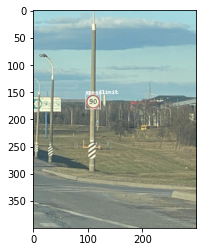

In [19]:
def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

### Partition the dataset

In [20]:
!dir 

RoadSignDetectionDataset.zip  __MACOSX			 annotations  yolov5
Road_Sign_Dataset	      __notebook_source__.ipynb  images


In [21]:
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images')]
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

In [22]:
# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [23]:
!mkdir images/train images/val images/test annotations/train annotations/val annotations/test

In [24]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False
                     

In [25]:
# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')
move_files_to_folder(test_annotations, 'annotations/test/')

In [26]:
!mv annotations labels # change name annotations to labels

In [28]:
!cd ./yolov5

In [34]:
!dir Road_Sign_Dataset/

In [37]:
shutil.move('./images/','./Road_Sign_Dataset/')

'./Road_Sign_Dataset/images'

In [38]:
shutil.move('./labels/','./Road_Sign_Dataset/')

'./Road_Sign_Dataset/labels'

### need to add yaml file for custom training path and data set

In [39]:
!wget -P ./yolov5/data/ https://gist.githubusercontent.com/ayooshkathuria/bcf7e3c929cbad445439c506dba6198d/raw/f437350c0c17c4eaa1e8657a5cb836e65d8aa08a/road_sign_data.yaml

--2022-05-14 12:01:19--  https://gist.githubusercontent.com/ayooshkathuria/bcf7e3c929cbad445439c506dba6198d/raw/f437350c0c17c4eaa1e8657a5cb836e65d8aa08a/road_sign_data.yaml
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220 [text/plain]
Saving to: ‘./yolov5/data/road_sign_data.yaml’

road_sign_data.yaml 100%[===================>]     220  --.-KB/s    in 0s      

2022-05-14 12:01:19 (11.6 MB/s) - ‘./yolov5/data/road_sign_data.yaml’ saved [220/220]



### Train

In [40]:
!dir ./yolov5/data/

Argoverse.yaml	      VOC.yaml	     hyps		  xView.yaml
GlobalWheat2020.yaml  VisDrone.yaml  images
Objects365.yaml       coco.yaml      road_sign_data.yaml
SKU-110K.yaml	      coco128.yaml   scripts


In [41]:
!dir ./Road_Sign_Dataset

images	labels


In [42]:
!cat ./yolov5/data/road_sign_data.yaml

train: ../Road_Sign_Dataset/images/train/ 
val:  ../Road_Sign_Dataset/images/val/
test: ../Road_Sign_Dataset/images/test/

# number of classes
nc: 4

# class names
names: ["trafficlight","stop", "speedlimit","crosswalk"]

In [43]:
!python ./yolov5/train.py --img 640 --cfg ./yolov5/models/yolov5s.yaml --hyp ./yolov5/data/hyps/hyp.scratch-low.yaml --batch 32 --epochs 100 --data ./yolov5/data/road_sign_data.yaml --weights yolov5s.pt --workers 24 --name yolo_road_det

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5s.pt, cfg=./yolov5/models/yolov5s.yaml, data=./yolov5/data/road_sign_data.yaml, hyp=./yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=yolov5/runs/train, name=yolo_road_det, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-184-g9d8ed37 torch 1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

h

In [45]:
!rm RoadSignDetectionDataset.zip

In [47]:
!dir yolov5/runs/train/yolo_road_det

F1_curve.png					   results.csv
PR_curve.png					   results.png
P_curve.png					   train_batch0.jpg
R_curve.png					   train_batch1.jpg
confusion_matrix.png				   train_batch2.jpg
events.out.tfevents.1652529742.55a2160ee210.471.0  val_batch0_labels.jpg
hyp.yaml					   val_batch0_pred.jpg
labels.jpg					   val_batch1_labels.jpg
labels_correlogram.jpg				   val_batch1_pred.jpg
opt.yaml					   weights


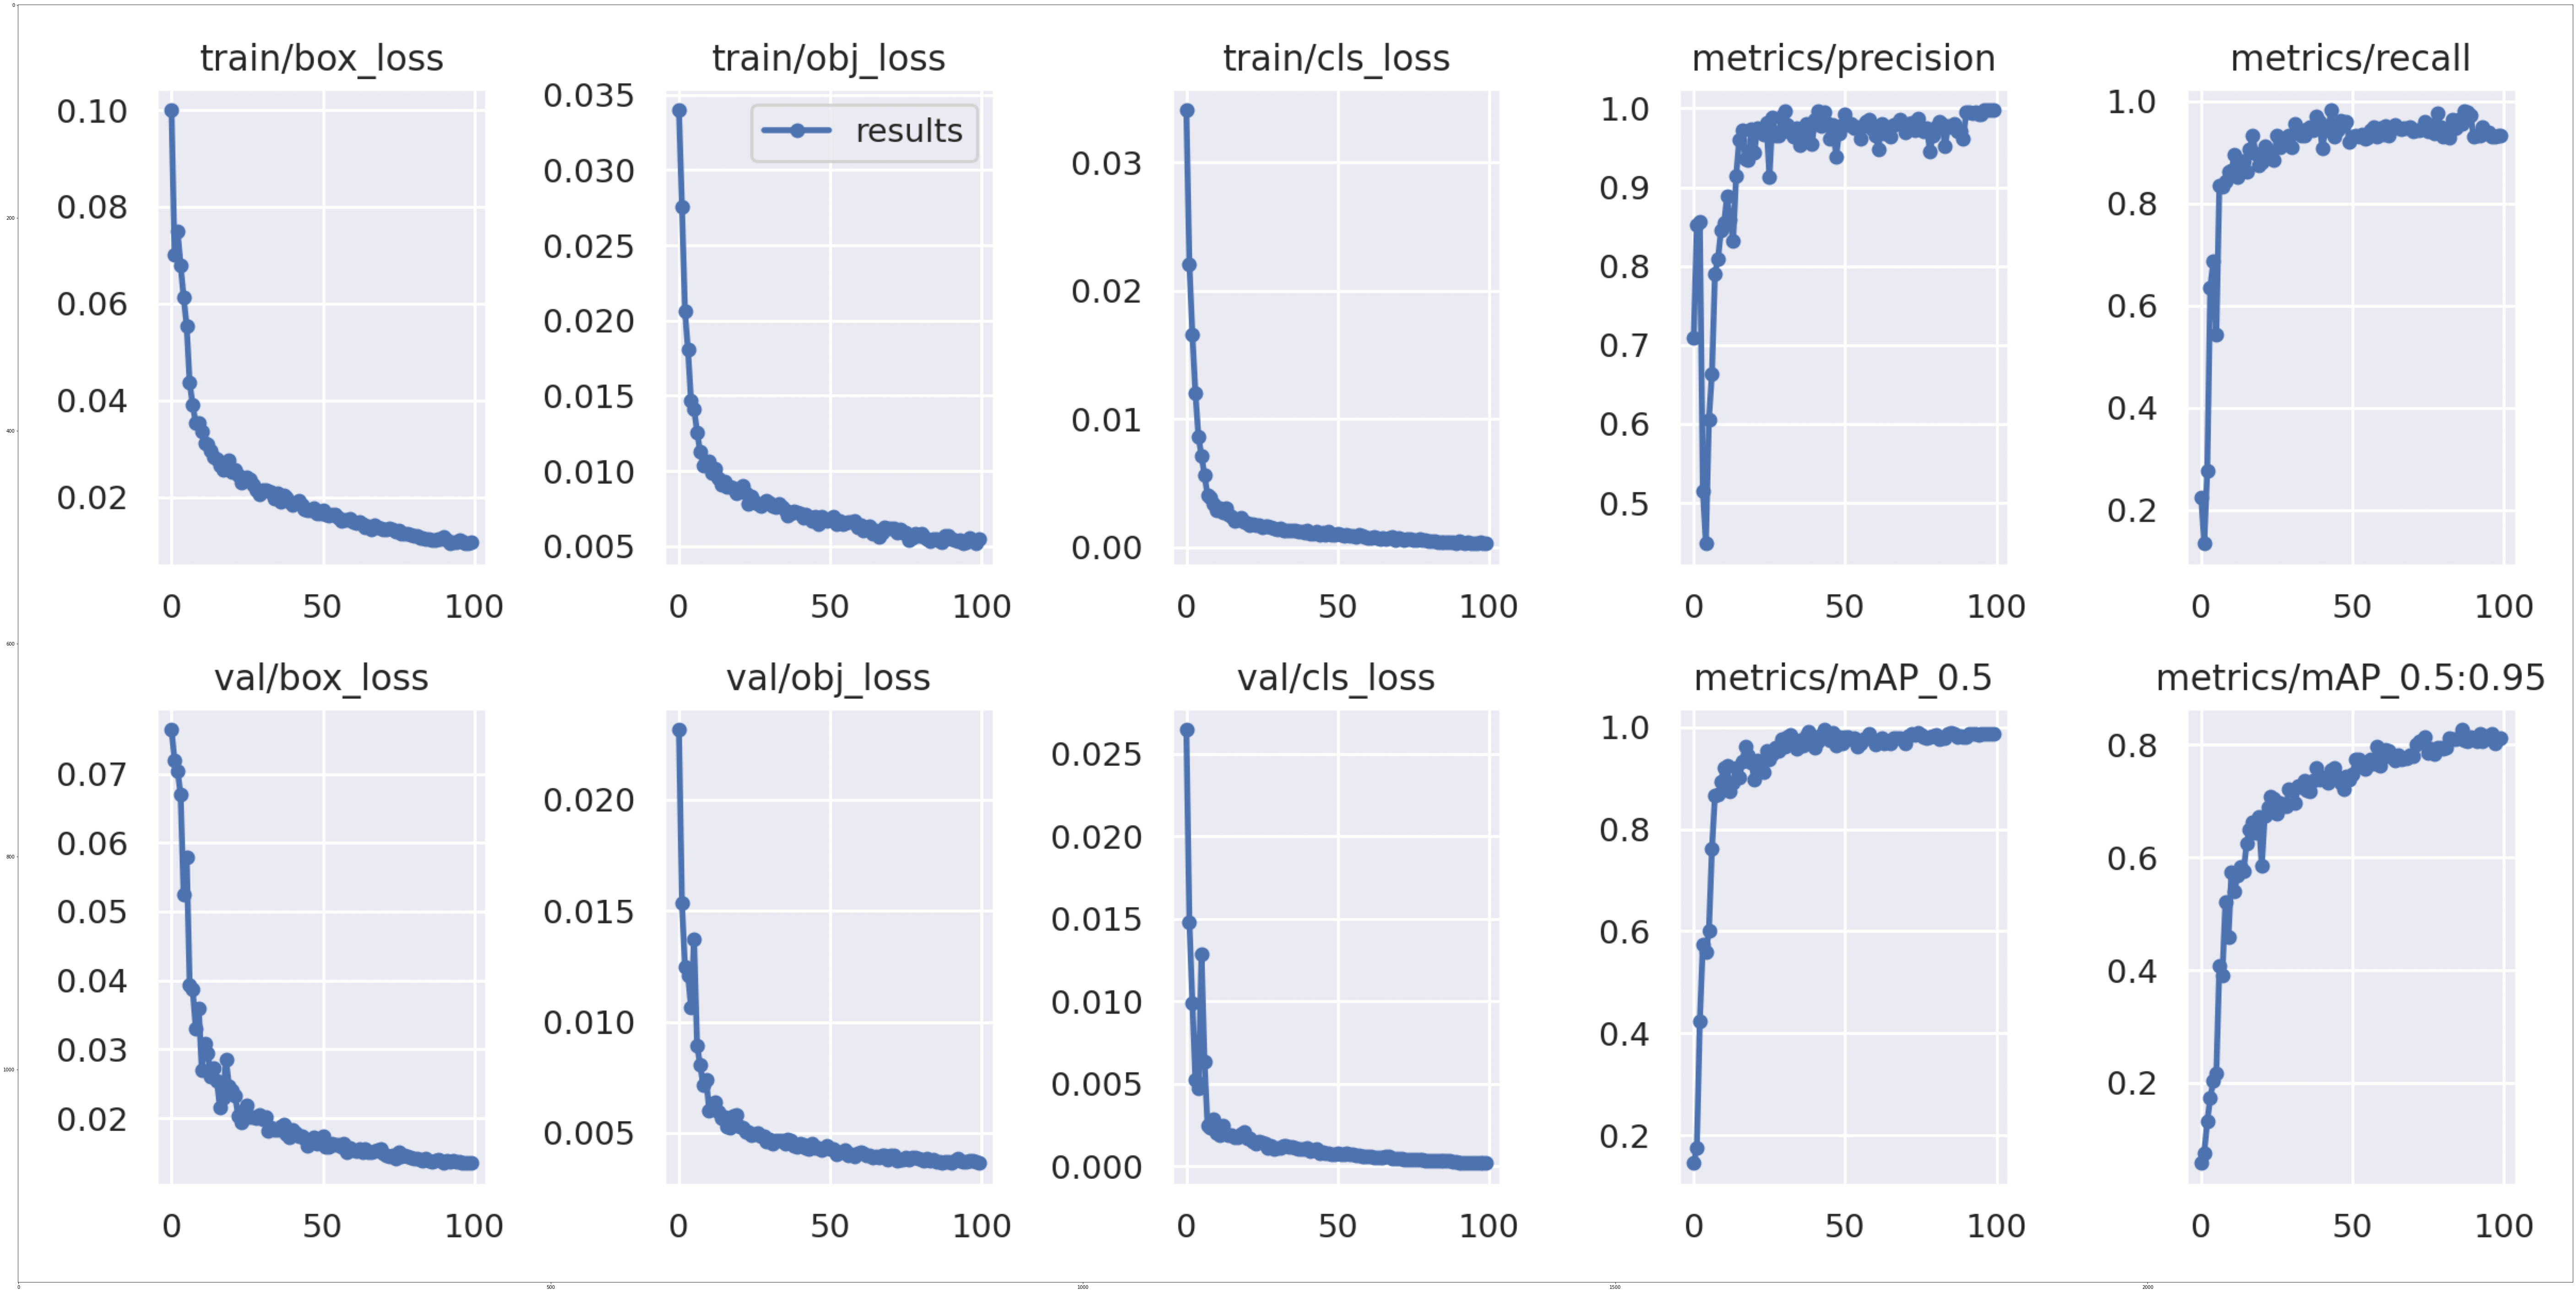

In [65]:
from matplotlib import pyplot as plt

plt.figure(figsize = (100,100))
img = plt.imread('yolov5/runs/train/yolo_road_det/results.png')
plt.imshow(img)

In [63]:
!cat yolov5/runs/train/yolo_road_det/hyp.yaml

lr0: 0.01
lrf: 0.01
momentum: 0.937
weight_decay: 0.0005
warmup_epochs: 3.0
warmup_momentum: 0.8
warmup_bias_lr: 0.1
box: 0.05
cls: 0.5
cls_pw: 1.0
obj: 1.0
obj_pw: 1.0
iou_t: 0.2
anchor_t: 4.0
fl_gamma: 0.0
hsv_h: 0.015
hsv_s: 0.7
hsv_v: 0.4
degrees: 0.0
translate: 0.1
scale: 0.5
shear: 0.0
perspective: 0.0
flipud: 0.0
fliplr: 0.5
mosaic: 1.0
mixup: 0.0
copy_paste: 0.0


In [66]:
shutil.make_archive('theoutput', 'zip', './yolov5/runs/train/yolo_road_det')

'/kaggle/working/theoutput.zip'